# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=40,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 40)
OOV context shape: (16562, 28)
Right context shape: (16562, 40)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-4.3283049e-30,  4.5556213e-41, -4.3283049e-30, ...,
         4.5554812e-41,  1.0480031e-40,  0.0000000e+00],
       [-6.0659576e+37,  4.5554812e-41, -1.0820081e+38, ...,
         4.5554812e-41, -1.0820666e+38,  4.5554812e-41],
       [ 1.0481572e-40,  0.0000000e+00, -6.0661361e+37, ...,
         0.0000000e+00, -6.0662983e+37,  4.5554812e-41],
       ...,
       [ 1.0654773e-40,  0.0000000e+00, -7.9007388e+36, ...,
         0.0000000e+00, -7.9009417e+36,  4.5554812e-41],
       [-1.0906403e+38,  4.5554812e-41,  1.0656314e-40, ...,
         4.5554812e-41,  1.0657716e-40,  0.0000000e+00],
       [-7.9011648e+36,  4.5554812e-41, -1.0907117e+38, ...,
         4.5554812e-41, -1.0907766e+38,  4.5554812e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=6.2199 | F1Score=0.2700
Batch-100: NLLLoss=5.6037 | F1Score=0.2919
Batch-150: NLLLoss=5.1191 | F1Score=0.3223
Batch-200: NLLLoss=5.3037 | F1Score=0.3463
Batch-250: NLLLoss=3.7531 | F1Score=0.3641
Batch-300: NLLLoss=4.8755 | F1Score=0.3808
Batch-350: NLLLoss=3.9307 | F1Score=0.3970
Batch-400: NLLLoss=4.0302 | F1Score=0.4103
Batch-450: NLLLoss=3.8817 | F1Score=0.4226
Batch-500: NLLLoss=2.6488 | F1Score=0.4347
Batch-518: NLLLoss=4.6665 | F1Score=0.4394

Mean NLLLoss: 4.4866 | Mean F1Score: 0.3544

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=3.6690 | F1Score=0.5987
Batch-100: NLLLoss=2.8972 | F1Score=0.6051
Batch-150: NLLLoss=2.6695 | F1Score=0.6051
Batch-200: NLLLoss=2.4640 | F1Score=0.6094
Batch-250: NLLLoss=2.5673 | F1Score=0.6177
Batch-300: NLLLoss=3.5517 | F1Score=0.6233
Batch-350: NLLLoss=2.5056 | F1Score=0.6276
Batch-400: NLLLoss=2.2161 | F1Score=0.6324
Batch-450: NLLLoss=2.5203 | F1Score=0.6373
Batch-500: NLLLoss=2.9539 | F1Score=0.6414
Batch-518: NLLLoss=2.5672 | F1Score=0.6438

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6820 | Mean F1Score: 0.6180

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.9111 | F1Score=0.7169
Batch-100: NLLLoss=2.0774 | F1Score=0.7181
Batch-150: NLLLoss=2.0717 | F1Score=0.7200
Batch-200: NLLLoss=1.2998 | F1Score=0.7241
Batch-250: NLLLoss=1.9750 | F1Score=0.7287
Batch-300: NLLLoss=1.4596 | F1Score=0.7302
Batch-350: NLLLoss=1.8174 | F1Score=0.7324
Batch-400: NLLLoss=1.0962 | F1Score=0.7364
Batch-450: NLLLoss=1.7826 | F1Score=0.7403
Batch-500: NLLLoss=2.1421 | F1Score=0.7435
Batch-518: NLLLoss=0.9067 | F1Score=0.7452

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7844 | Mean F1Score: 0.7282

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.2474 | F1Score=0.8219
Batch-100: NLLLoss=0.8562 | F1Score=0.8173
Batch-150: NLLLoss=1.3083 | F1Score=0.8161
Batch-200: NLLLoss=2.0849 | F1Score=0.8154
Batch-250: NLLLoss=1.5020 | F1Score=0.8134
Batch-300: NLLLoss=1.7822 | F1Score=0.8151
Batch-350: NLLLoss=1.2784 | F1Score=0.8118
Batch-400: NLLLoss=1.1490 | F1Score=0.8147
Batch-450: NLLLoss=1.7197 | F1Score=0.8160
Batch-500: NLLLoss=1.2731 | F1Score=0.8166
Batch-518: NLLLoss=0.5068 | F1Score=0.8170

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1657 | Mean F1Score: 0.8141

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4854 | F1Score=0.8863
Batch-100: NLLLoss=0.9423 | F1Score=0.8797
Batch-150: NLLLoss=0.8478 | F1Score=0.8797
Batch-200: NLLLoss=0.2579 | F1Score=0.8787
Batch-250: NLLLoss=0.9493 | F1Score=0.8753
Batch-300: NLLLoss=0.8632 | F1Score=0.8718
Batch-350: NLLLoss=0.3548 | F1Score=0.8713
Batch-400: NLLLoss=1.0905 | F1Score=0.8707
Batch-450: NLLLoss=0.7949 | F1Score=0.8697
Batch-500: NLLLoss=0.1889 | F1Score=0.8697
Batch-518: NLLLoss=0.2103 | F1Score=0.8699

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6994 | Mean F1Score: 0.8770

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2109 | F1Score=0.9475
Batch-100: NLLLoss=0.3653 | F1Score=0.9523
Batch-150: NLLLoss=0.0460 | F1Score=0.9520
Batch-200: NLLLoss=0.2043 | F1Score=0.9467
Batch-250: NLLLoss=0.4314 | F1Score=0.9446
Batch-300: NLLLoss=0.4535 | F1Score=0.9411
Batch-350: NLLLoss=0.4997 | F1Score=0.9406
Batch-400: NLLLoss=0.4348 | F1Score=0.9397
Batch-450: NLLLoss=0.4703 | F1Score=0.9374
Batch-500: NLLLoss=0.1652 | F1Score=0.9364
Batch-518: NLLLoss=0.0760 | F1Score=0.9358

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3490 | Mean F1Score: 0.9447

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1214 | F1Score=0.9869
Batch-100: NLLLoss=0.1061 | F1Score=0.9881
Batch-150: NLLLoss=0.0621 | F1Score=0.9879
Batch-200: NLLLoss=0.0789 | F1Score=0.9880
Batch-250: NLLLoss=0.1228 | F1Score=0.9885
Batch-300: NLLLoss=0.1234 | F1Score=0.9883
Batch-350: NLLLoss=0.1078 | F1Score=0.9881
Batch-400: NLLLoss=0.2006 | F1Score=0.9873
Batch-450: NLLLoss=0.2465 | F1Score=0.9874
Batch-500: NLLLoss=0.1450 | F1Score=0.9869
Batch-518: NLLLoss=0.1675 | F1Score=0.9867

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1178 | Mean F1Score: 0.9880

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0127 | F1Score=0.9994
Batch-100: NLLLoss=0.1373 | F1Score=0.9975
Batch-150: NLLLoss=0.0248 | F1Score=0.9975
Batch-200: NLLLoss=0.0201 | F1Score=0.9977
Batch-250: NLLLoss=0.0428 | F1Score=0.9978
Batch-300: NLLLoss=0.0284 | F1Score=0.9981
Batch-350: NLLLoss=0.0156 | F1Score=0.9980
Batch-400: NLLLoss=0.0365 | F1Score=0.9980
Batch-450: NLLLoss=0.0559 | F1Score=0.9982
Batch-500: NLLLoss=0.0500 | F1Score=0.9980
Batch-518: NLLLoss=0.1249 | F1Score=0.9979

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0319 | Mean F1Score: 0.9981

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0132 | F1Score=1.0000
Batch-100: NLLLoss=0.0092 | F1Score=1.0000
Batch-150: NLLLoss=0.0101 | F1Score=0.9995
Batch-200: NLLLoss=0.0070 | F1Score=0.9995
Batch-250: NLLLoss=0.0112 | F1Score=0.9994
Batch-300: NLLLoss=0.0109 | F1Score=0.9995
Batch-350: NLLLoss=0.0091 | F1Score=0.9996
Batch-400: NLLLoss=0.0056 | F1Score=0.9996
Batch-450: NLLLoss=0.0082 | F1Score=0.9994
Batch-500: NLLLoss=0.0080 | F1Score=0.9993
Batch-518: NLLLoss=0.0095 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0125 | Mean F1Score: 0.9996

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0052 | F1Score=0.9994
Batch-100: NLLLoss=0.0058 | F1Score=0.9995
Batch-150: NLLLoss=0.0028 | F1Score=0.9996
Batch-200: NLLLoss=0.0053 | F1Score=0.9997
Batch-250: NLLLoss=0.0044 | F1Score=0.9997
Batch-300: NLLLoss=0.0087 | F1Score=0.9998
Batch-350: NLLLoss=0.0042 | F1Score=0.9997
Batch-400: NLLLoss=0.0059 | F1Score=0.9995
Batch-450: NLLLoss=0.0043 | F1Score=0.9995
Batch-500: NLLLoss=0.0072 | F1Score=0.9996
Batch-518: NLLLoss=0.0014 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0067 | Mean F1Score: 0.9996

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0032 | F1Score=0.9987
Batch-100: NLLLoss=0.0031 | F1Score=0.9994
Batch-150: NLLLoss=0.0069 | F1Score=0.9992
Batch-200: NLLLoss=0.0041 | F1Score=0.9994
Batch-250: NLLLoss=0.0028 | F1Score=0.9995
Batch-300: NLLLoss=0.0066 | F1Score=0.9996
Batch-350: NLLLoss=0.0036 | F1Score=0.9996
Batch-400: NLLLoss=0.0033 | F1Score=0.9995
Batch-450: NLLLoss=0.0030 | F1Score=0.9994
Batch-500: NLLLoss=0.0056 | F1Score=0.9994
Batch-518: NLLLoss=0.0047 | F1Score=0.9994

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0062 | Mean F1Score: 0.9992

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0044 | F1Score=0.9994
Batch-100: NLLLoss=0.0018 | F1Score=0.9997
Batch-150: NLLLoss=0.0009 | F1Score=0.9996
Batch-200: NLLLoss=0.0032 | F1Score=0.9997
Batch-250: NLLLoss=0.0023 | F1Score=0.9998
Batch-300: NLLLoss=0.0036 | F1Score=0.9997
Batch-350: NLLLoss=0.0043 | F1Score=0.9997
Batch-400: NLLLoss=0.0025 | F1Score=0.9997
Batch-450: NLLLoss=0.0019 | F1Score=0.9997
Batch-500: NLLLoss=0.0028 | F1Score=0.9997
Batch-518: NLLLoss=0.0032 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0042 | Mean F1Score: 0.9997

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0014 | F1Score=1.0000
Batch-100: NLLLoss=0.0011 | F1Score=1.0000
Batch-150: NLLLoss=0.0013 | F1Score=1.0000
Batch-200: NLLLoss=0.0019 | F1Score=1.0000
Batch-250: NLLLoss=0.0014 | F1Score=0.9999
Batch-300: NLLLoss=0.0016 | F1Score=0.9999
Batch-350: NLLLoss=0.0016 | F1Score=0.9999
Batch-400: NLLLoss=0.0014 | F1Score=0.9999
Batch-450: NLLLoss=0.0019 | F1Score=0.9999
Batch-500: NLLLoss=0.0040 | F1Score=0.9998
Batch-518: NLLLoss=0.0017 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0024 | Mean F1Score: 0.9999

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0031 | F1Score=1.0000
Batch-100: NLLLoss=0.0016 | F1Score=1.0000
Batch-150: NLLLoss=0.0014 | F1Score=1.0000
Batch-200: NLLLoss=0.0022 | F1Score=1.0000
Batch-250: NLLLoss=0.0237 | F1Score=0.9998
Batch-300: NLLLoss=0.0170 | F1Score=0.9996
Batch-350: NLLLoss=0.4329 | F1Score=0.9824
Batch-400: NLLLoss=0.7749 | F1Score=0.9653
Batch-450: NLLLoss=0.3389 | F1Score=0.9567
Batch-500: NLLLoss=0.2446 | F1Score=0.9523
Batch-518: NLLLoss=0.0041 | F1Score=0.9506

Huft 😥! Model not improved.
Mean NLLLoss: 0.2026 | Mean F1Score: 0.9869
Patience = 1/20❗

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.3095 | F1Score=0.9475
Batch-100: NLLLoss=0.2243 | F1Score=0.9522
Batch-150: NLLLoss=0.0555 | F1Score=0.9575
Batch-200: NLLLoss=0.0998 | F1Score=0.9602
Batch-250: NLLLoss=0.0894 | F1Score=0.9626
Batch-300: NLLLoss=0.1753 | F1Score=0.9658
Batch-350: NLLLoss=0.1999 | F1Score=0.9667
Batch-400: NLLLoss=0.0409 | F1Score=0.9684
Batch-450: NLLLoss=0.1224 | F1Score=0.9694
Batch-500: NLLLoss=0.2354 | F1Score=0.9698
Batch-518: NLLLoss=0.0348 | F1Score=0.9704

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1235 | Mean F1Score: 0.9597

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0085 | F1Score=0.9994
Batch-100: NLLLoss=0.0086 | F1Score=0.9977
Batch-150: NLLLoss=0.0015 | F1Score=0.9984
Batch-200: NLLLoss=0.0039 | F1Score=0.9988
Batch-250: NLLLoss=0.0050 | F1Score=0.9991
Batch-300: NLLLoss=0.0049 | F1Score=0.9992
Batch-350: NLLLoss=0.0017 | F1Score=0.9992
Batch-400: NLLLoss=0.0028 | F1Score=0.9991
Batch-450: NLLLoss=0.0016 | F1Score=0.9991
Batch-500: NLLLoss=0.0006 | F1Score=0.9991
Batch-518: NLLLoss=0.0013 | F1Score=0.9991

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0088 | Mean F1Score: 0.9989

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0018 | F1Score=1.0000
Batch-100: NLLLoss=0.0028 | F1Score=0.9997
Batch-150: NLLLoss=0.0017 | F1Score=0.9998
Batch-200: NLLLoss=0.0016 | F1Score=0.9998
Batch-250: NLLLoss=0.0008 | F1Score=0.9997
Batch-300: NLLLoss=0.0017 | F1Score=0.9998
Batch-350: NLLLoss=0.0023 | F1Score=0.9998
Batch-400: NLLLoss=0.0011 | F1Score=0.9998
Batch-450: NLLLoss=0.0018 | F1Score=0.9999
Batch-500: NLLLoss=0.0017 | F1Score=0.9999
Batch-518: NLLLoss=0.0018 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0019 | Mean F1Score: 0.9998

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0017 | F1Score=1.0000
Batch-100: NLLLoss=0.0012 | F1Score=1.0000
Batch-150: NLLLoss=0.0009 | F1Score=1.0000
Batch-200: NLLLoss=0.0016 | F1Score=1.0000
Batch-250: NLLLoss=0.0014 | F1Score=1.0000
Batch-300: NLLLoss=0.0010 | F1Score=1.0000
Batch-350: NLLLoss=0.0013 | F1Score=1.0000
Batch-400: NLLLoss=0.0010 | F1Score=1.0000
Batch-450: NLLLoss=0.0005 | F1Score=0.9999
Batch-500: NLLLoss=0.0011 | F1Score=0.9999
Batch-518: NLLLoss=0.0012 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0011 | Mean F1Score: 1.0000

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0012 | F1Score=1.0000
Batch-100: NLLLoss=0.0006 | F1Score=1.0000
Batch-150: NLLLoss=0.0011 | F1Score=1.0000
Batch-200: NLLLoss=0.0010 | F1Score=1.0000
Batch-250: NLLLoss=0.0011 | F1Score=1.0000
Batch-300: NLLLoss=0.0008 | F1Score=1.0000
Batch-350: NLLLoss=0.0004 | F1Score=1.0000
Batch-400: NLLLoss=0.0008 | F1Score=1.0000
Batch-450: NLLLoss=0.0008 | F1Score=1.0000
Batch-500: NLLLoss=0.0013 | F1Score=0.9999
Batch-518: NLLLoss=0.0008 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0009 | Mean F1Score: 1.0000

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0005 | F1Score=1.0000
Batch-150: NLLLoss=0.0010 | F1Score=1.0000
Batch-200: NLLLoss=0.0009 | F1Score=0.9999
Batch-250: NLLLoss=0.0007 | F1Score=0.9999
Batch-300: NLLLoss=0.0004 | F1Score=0.9999
Batch-350: NLLLoss=0.0005 | F1Score=0.9999
Batch-400: NLLLoss=0.0007 | F1Score=0.9999
Batch-450: NLLLoss=0.0009 | F1Score=0.9999
Batch-500: NLLLoss=0.0015 | F1Score=0.9999
Batch-518: NLLLoss=0.0003 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0007 | Mean F1Score: 1.0000

TRAINING SUMMARY
Best NLLLoss      : 0.0007
Best F1Score      : 1.0000
Training duration : 25.675 minutes.
Training date     : 2022-10-11 13:47:43.838849+08:00


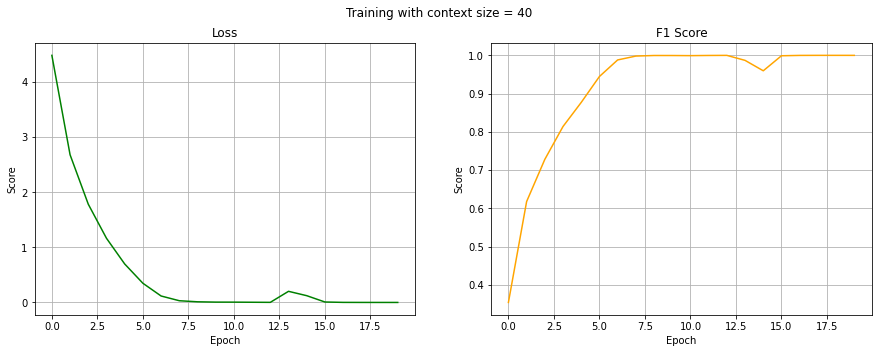

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[-1.9588763 , -4.208417  , -4.2313395 , ..., -0.54904115,
        -1.1717591 ,  0.3354122 ],
       [-2.670443  ,  0.28272033, -1.650678  , ..., -3.8783855 ,
         3.4852262 ,  5.5110903 ],
       [-5.8808265 ,  3.3411117 ,  0.3063033 , ...,  0.6387613 ,
         1.6119611 ,  2.2606153 ],
       ...,
       [-7.0227976 ,  3.7781048 , -2.1947558 , ..., -1.6572292 ,
         2.0973978 ,  2.3124058 ],
       [-2.4176395 , -8.586711  , -2.8833697 , ...,  1.3964037 ,
         0.7760628 , -2.7612195 ],
       [-4.5948033 ,  4.3068867 , -0.42587656, ...,  3.8149922 ,
         3.9430692 ,  3.647541  ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[-1.0647e-01, -2.5548e-01, -2.2549e-01,  ...,  3.8735e-01,
                        1.6080e-02, -6.1852e-01],
                      [ 2.1382e-01,  1.9758e-03, -4.1307e-02,  ..., -1.5636e-04,
                        5.5709e-01, -2.6966e-01],
                      [-1.0535e-01, -1.1995e-01,  1.1441e-01,  ...,  3.3186e-02,
                        8.2207e-02, -1.2483e-01],
                      ...,
                      [ 4.0204e-01, -2.2198e-01, -2.6634e-01,  ..., -4.6819e-01,
                       -2.9717e-01, -3.2120e-01],
                      [-9.2598e-02,  3.3359e-02, -1.7449e-01,  ..., -1.8969e-01,
                       -2.4914e-01, -3.1022e-01],
                      [ 2.0461e-01, -1.6637e-01,  4.7581e-01,  ..., -2.8355e-02,
                       -1.1433e-01,  9.1966e-03]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.2400,  0.1157, -0.1030,  ..., -0.0318, -0.